# Automatic detection of motion artefacts in the ECG signal from a wearable sensor using methods of artificial intelligence
## Master's thesis

In [ ]:
!pip install neptune-tensorflow-keras

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

## Helper functions

In [2]:
'''
    Function used to plot training and validation progress
'''
def plot_metrics(history, metric):
    train = history.history[metric]
    val = history.history['val_' + str(metric)]

    plt.figure(figsize=(10, 5))
    
    plt.plot(train, label='Training ' + str(metric), color='blue')
    plt.plot(val, label='Validation ' + str(metric), color='red')
    plt.title('Training and validation ' + str(metric))
    plt.xlabel('Epoch')
    plt.ylabel(str(metric).capitalize())
    
    plt.legend()
    plt.show()

In [3]:
'''
    Function used to plot confusion matrix for multi class classification
'''
def plot_confusion_matrix(y_test, y_pred, class_labels):
    # Compute confusion matrix
    conf_mat = confusion_matrix(np.array(y_test), np.array(y_pred))

    # Normalize confusion matrix to show percentages
    conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot heatmap with annotations
    sns.heatmap(conf_mat_norm, 
                annot=True, 
                fmt='.2%', 
                cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                ax=ax
               )
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Normalized)')
    
    plt.show()
    
    return fig

## Dataset creation
- Traverse the data directory to create data file - label file pairs
- Go through all of the pairs and construct the output dataframe - extract corresponding segment from signal and include artefact and activity type labels

In [4]:
PARENT_DIR = '../../data'

ACTIVITIES_NUM = 5
ARTEFACT_NUM = 4

SEG_LEN = 2
FS = 500

In [5]:
df = pd.DataFrame(columns = ['artefact_label', 'activity_label'])

data_label_pairs = {}
data = []

In [6]:
# Traverse all ID directories to get the data-label file pairs
for id_dir in os.listdir(PARENT_DIR):
    data_dir = os.path.join(PARENT_DIR, id_dir)
    
    # Check if the path is a directory
    if os.path.isdir(data_dir):
        labels_dir = os.path.join(data_dir, 'labels')
        
        # Double check that data and labels subdirectories exist
        if os.path.exists(data_dir) and os.path.exists(labels_dir):
            
            # Iterate over .csv files in data directory
            for data_file in os.listdir(data_dir):
                if data_file.endswith('.csv'):
                    
                    # Check if corresponding label file exists
                    label_file_name = data_file.split('.')[0] + '_' + str(SEG_LEN) + '.csv'
                    
                    label_path = os.path.join(labels_dir, label_file_name)
                    data_path = os.path.join(data_dir, data_file)
                    
                    if os.path.exists(data_path) and os.path.exists(label_path):
                        data_label_pairs[data_path] = label_path

In [7]:
# Iterate over matched data-label pairs
for data_file, label_file in data_label_pairs.items():
    df_data = pd.read_csv(data_file, delimiter=';', names=['timestamp', 'value'])
    
    df_labels = pd.read_csv(label_file, delimiter=';')

    # Iterate over rows in label file
    for idx, row in df_labels.iterrows():
        # Extract segment from data based on start and end indices
        start_idx, end_idx = row['start'], row['end']
        segment = df_data.iloc[start_idx:end_idx]['value'].values

        segment_df = pd.DataFrame(segment, columns=['segment'])
        
        segment = segment_df.T
        
        # Add activity_type and artefact_type columns
        segment['activity'] = row['activity']
        segment['artefact'] = row['artifact']
        
        data.append(segment)

df = pd.concat(data, ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,activity,artefact
0,2134,2125,2130,2131,2137,2136,2143,2141,2149,2155,...,2066,2060,2055,2053,2054,2046,2042,2043,0,1
1,2042,2041,2042,2039,2036,2034,2033,2029,2026,2028,...,2108,2117,2127,2133,2147,2145,2149,2150,0,1
2,2148,2149,2150,2154,2154,2157,2161,2165,2164,2153,...,2090,2097,2103,2107,2114,2121,2119,2117,0,1
3,2120,2125,2121,2125,2125,2124,2124,2119,2108,2104,...,2270,2272,2273,2275,2275,2277,2278,2281,0,1
4,2280,2278,2280,2282,2278,2280,2272,2271,2272,2272,...,2140,2151,2167,2180,2200,2207,2214,2218,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,2612,2614,2591,2535,2445,2311,2143,1956,1744,1522,...,2101,2115,2128,2138,2142,2136,2107,2059,3,2
3652,2022,1983,1965,1945,1935,1932,1938,1944,1948,1960,...,2147,2181,2209,2218,2214,2205,2194,2180,3,2
3653,2167,2152,2164,2172,2178,2190,2211,2232,2245,2268,...,2027,2031,2015,1973,1915,1828,1710,1577,3,2
3654,1427,1256,1067,875,691,526,393,260,186,189,...,2673,2643,2591,2555,2534,2518,2503,2490,3,2


## Data preprocessing
- Normalize the data to the range of a 12-bit ADC using min-max normalization
- Split the dataset into training and testing set
- One-hot encode data labels, to match the output shape of the model

In [8]:
target_columns = ['activity', 'artefact']
min_val, max_val = 0, 4096

# Min-max normalized data
normalized = (df.loc[:, ~df.columns.isin(target_columns)] - min_val) / (max_val - min_val)

# Apply min-max normalization to each column
df_norm = df.copy()

df_norm.loc[:, ~df_norm.columns.isin(target_columns)] = normalized
df_norm

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,activity,artefact
0,0.520996,0.518799,0.520020,0.520264,0.521729,0.521484,0.523193,0.522705,0.524658,0.526123,...,0.504395,0.502930,0.501709,0.501221,0.501465,0.499512,0.498535,0.498779,0,1
1,0.498535,0.498291,0.498535,0.497803,0.497070,0.496582,0.496338,0.495361,0.494629,0.495117,...,0.514648,0.516846,0.519287,0.520752,0.524170,0.523682,0.524658,0.524902,0,1
2,0.524414,0.524658,0.524902,0.525879,0.525879,0.526611,0.527588,0.528564,0.528320,0.525635,...,0.510254,0.511963,0.513428,0.514404,0.516113,0.517822,0.517334,0.516846,0,1
3,0.517578,0.518799,0.517822,0.518799,0.518799,0.518555,0.518555,0.517334,0.514648,0.513672,...,0.554199,0.554688,0.554932,0.555420,0.555420,0.555908,0.556152,0.556885,0,1
4,0.556641,0.556152,0.556641,0.557129,0.556152,0.556641,0.554688,0.554443,0.554688,0.554688,...,0.522461,0.525146,0.529053,0.532227,0.537109,0.538818,0.540527,0.541504,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,0.637695,0.638184,0.632568,0.618896,0.596924,0.564209,0.523193,0.477539,0.425781,0.371582,...,0.512939,0.516357,0.519531,0.521973,0.522949,0.521484,0.514404,0.502686,3,2
3652,0.493652,0.484131,0.479736,0.474854,0.472412,0.471680,0.473145,0.474609,0.475586,0.478516,...,0.524170,0.532471,0.539307,0.541504,0.540527,0.538330,0.535645,0.532227,3,2
3653,0.529053,0.525391,0.528320,0.530273,0.531738,0.534668,0.539795,0.544922,0.548096,0.553711,...,0.494873,0.495850,0.491943,0.481689,0.467529,0.446289,0.417480,0.385010,3,2
3654,0.348389,0.306641,0.260498,0.213623,0.168701,0.128418,0.095947,0.063477,0.045410,0.046143,...,0.652588,0.645264,0.632568,0.623779,0.618652,0.614746,0.611084,0.607910,3,2


In [9]:
df_norm['activity'].value_counts()

1    739
4    737
3    734
0    731
2    715
Name: activity, dtype: int64

In [10]:
# Train test split
X = df_norm.drop(target_columns, axis=1).copy()

y_activity = df_norm['activity'].copy()
y_artefact = df_norm['artefact'].copy()

X_train, X_test, y_train_act, y_test_act = train_test_split(X, y_activity, test_size=0.2, random_state=40)

# X_train, X_test, y_train_art, y_test_art = train_test_split(X, y_artefact, test_size=0.2, random_state=40)

In [11]:
# One-hot encoding
y_train_act_enc = tf.keras.utils.to_categorical(y_train_act, num_classes=ACTIVITIES_NUM)

# y_train_art_enc = tf.keras.utils.to_categorical(y_train_art, num_classes=ARTEFACT_NUM)

## Model architectures
Possible parameter options:
- __Loss:__ Categorical cross-entropy, Kullback-Leibler divergence behaviour in this case possibly the same as cross-entropy
- __Output activation:__ Softmax, nothing else makes much sense

In [41]:
params = {
    'epochs': 100,
    'batch_size': 16,
    'learning_rate': 0.0001, 
    'dropout': 0.0,
    'optimizer': 'Adam',
    'hidden_activation': 'relu',
    'output_activation': 'softmax',
    'loss': 'categorical_crossentropy',
    'metric': 'accuracy'
}

In [42]:
'''
    Activity type classification model
'''
def activity_classifier(seg_len, num_activities):
    # Input layer for ECG segments
    signal_input = Input(shape=(seg_len,), name = 'signal_input')
    
    # Fully connected and dropout layers
    dense1 = Dense(512, activation = params['hidden_activation'])(signal_input)
    dropout1 = Dropout(params['dropout'])(dense1) 
    
    dense2 = Dense(256, activation = params['hidden_activation'])(dropout1)
    dropout2 = Dropout(params['dropout'])(dense2)  
    
    dense3 = Dense(128, activation = params['hidden_activation'])(dropout2)
    dropout3 = Dropout(params['dropout'])(dense3)
    
    dense4 = Dense(64, activation = params['hidden_activation'])(dropout3)
    dropout4 = Dropout(params['dropout'])(dense4) 
    
    dense5 = Dense(32, activation = params['hidden_activation'])(dropout4)
    dropout5 = Dropout(params['dropout'])(dense5)
    
    # Output layer for activity prediction
    output = Dense(num_activities, activation = params['output_activation'], name = 'output')(dropout5)
    
    opt = Adam(learning_rate = params['learning_rate'])
    
    model = Model(inputs = signal_input, outputs = output)
    
    model.compile(optimizer = opt, loss = params['loss'], metrics = params['metric'])
    
    return model


# Segment length in samples
seg_len = FS * SEG_LEN 

model = activity_classifier(seg_len, ACTIVITIES_NUM)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 signal_input (InputLayer)   [(None, 1000)]            0         
                                                                 
 dense_35 (Dense)            (None, 512)               512512    
                                                                 
 dropout_35 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dropout_37 (Dropout)        (None, 128)               0   

## Training

In [43]:
# Init Neptune.ai project
run = neptune.init_run(
    project = 'veronika.kalouskova/DP-Activity-Classification',
    api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMTY5NGI5ZS0xNzk1LTQwYjItYjc0Ny1lZWNmZjdjZjg1MzEifQ==',
)

# Log model parameters into Neptune
run['parameters'] = params

# Log model summary and architecture into Neptune
neptune_callback = NeptuneCallback(run=run)

history = model.fit(X_train, 
                    y_train_act_enc, 
                    epochs = params['epochs'], 
                    batch_size = params['batch_size'], 
                    validation_split=0.1,
                    callbacks=[neptune_callback]
                   )

# Log model architecture and weights into Neptune
model.save('models/model.keras')

run['saved_model'].upload('models/model.keras')


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/veronika.kalouskova/DP-Activity-Classification/e/DUM-27
Epoch 1/100
165/165 [==============================] - 2s 6ms/step - loss: 1.6132 - accuracy: 0.2071 - val_loss: 1.6036 - val_accuracy: 0.2321
Epoch 2/100
165/165 [==============================] - 1s 5ms/step - loss: 1.6052 - accuracy: 0.2398 - val_loss: 1.6125 - val_accuracy: 0.1945
Epoch 3/100
165/165 [==============================] - 1s 6ms/step - loss: 1.5999 - accuracy: 0.2216 - val_loss: 1.6032 - val_accuracy: 0.2287
Epoch 4/100
165/165 [==============================] - 1s 5ms/step - loss: 1.5913 - accuracy: 0.2414 - val_loss: 1.6095 - val_accuracy: 0.2150
Epoch 5/100
165/165 [==============================] - 1s 6ms/step - loss: 1.5813 - accuracy: 0.2558 - val_loss: 1.5909 - val_accuracy: 0.2116
Epoch 6/100
165/165 [==============================] - 1s 6ms/step - loss: 1.5689 - accuracy: 0.2566 - val_loss: 1.5964 - val_accuracy: 0.2355
Epoch

165/165 [==============================] - 1s 6ms/step - loss: 0.9802 - accuracy: 0.5960 - val_loss: 1.5308 - val_accuracy: 0.3959
Epoch 58/100
165/165 [==============================] - 1s 6ms/step - loss: 1.0173 - accuracy: 0.5838 - val_loss: 1.4886 - val_accuracy: 0.4266
Epoch 59/100
165/165 [==============================] - 1s 6ms/step - loss: 0.9651 - accuracy: 0.5956 - val_loss: 1.4565 - val_accuracy: 0.4369
Epoch 60/100
165/165 [==============================] - 1s 6ms/step - loss: 0.9682 - accuracy: 0.6002 - val_loss: 1.4409 - val_accuracy: 0.4266
Epoch 61/100
165/165 [==============================] - 1s 6ms/step - loss: 0.9462 - accuracy: 0.6154 - val_loss: 1.4466 - val_accuracy: 0.4369
Epoch 62/100
165/165 [==============================] - 1s 6ms/step - loss: 0.9554 - accuracy: 0.6024 - val_loss: 1.4225 - val_accuracy: 0.4881
Epoch 63/100
165/165 [==============================] - 1s 6ms/step - loss: 0.9347 - accuracy: 0.6165 - val_loss: 1.4924 - val_accuracy: 0.4608
Epoch

## Evaluation

23/23 [==============================] - 0s 2ms/step


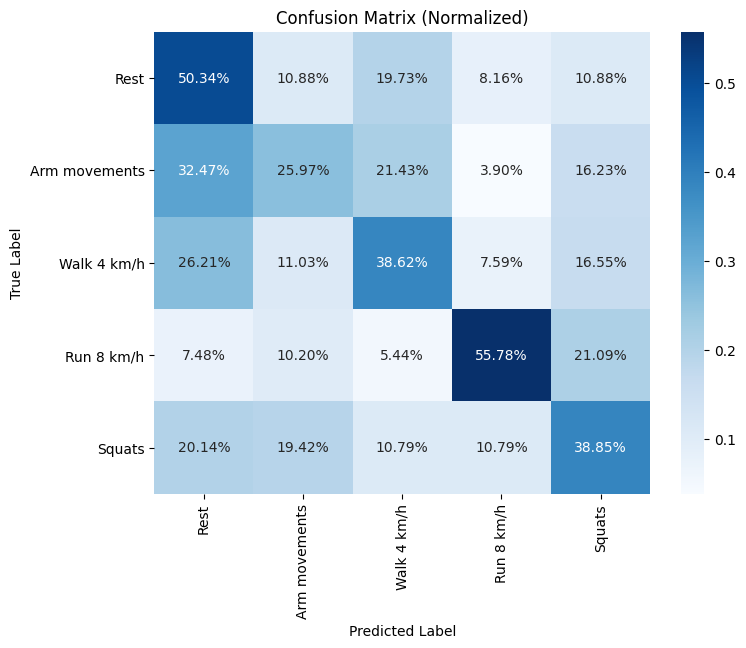

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/veronika.kalouskova/DP-Activity-Classification/e/DUM-26/metadata


In [40]:
preds_act = model.predict(X_test)
y_pred_act = np.argmax(preds_act, axis=1)

accuracy = accuracy_score(y_test_act, y_pred_act)
run["eval/accuracy"] = accuracy

class_labels = ['Rest', 'Arm movements', 'Walk 4 km/h', 'Run 8 km/h', 'Squats']

fig = plot_confusion_matrix(y_test_act, y_pred_act, class_labels)
run["eval/confusion_matrix"] = fig

run.stop()

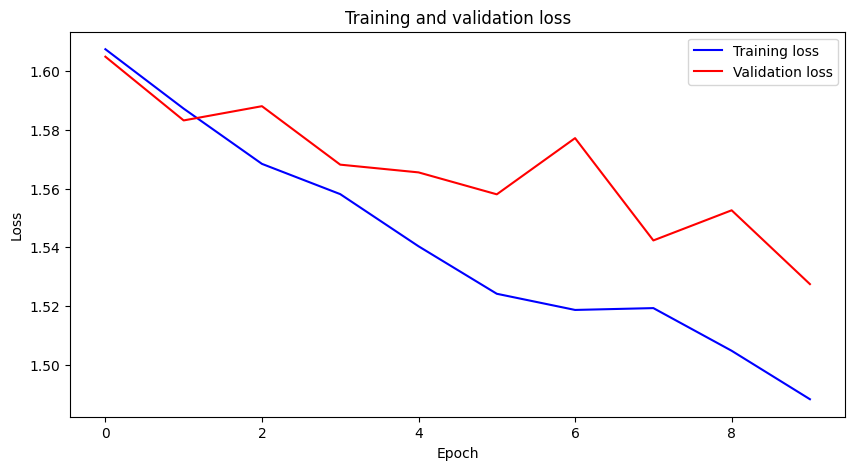

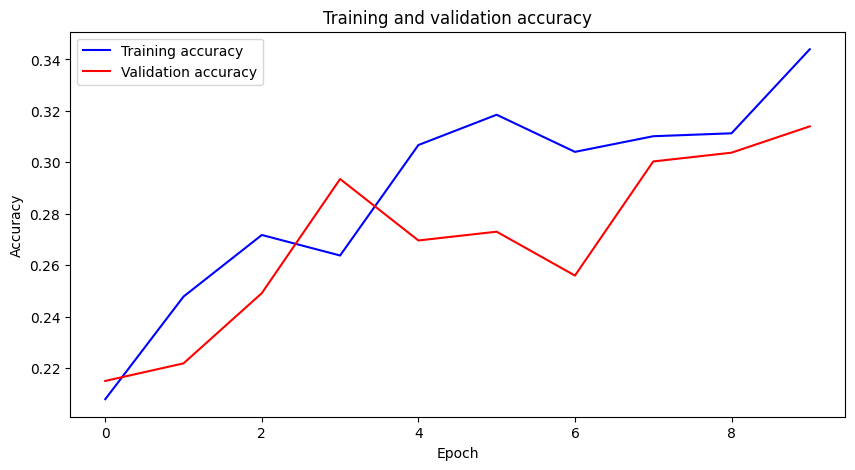

In [16]:
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')